In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from models import LS, CG

In [4]:
nk = nk_dead(500, 500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = 10
y = simple.func(X, theta_true)

In [5]:
ls = LS(y, simple, mean_X)
cg = CG(y, simple, mean_X, covinv_X)

In [8]:
theta_c = cg.minimise(theta_true)
logPr_max_c = cg.logPr(theta_c)
H_c = cg.hess(theta_c)
ds = np.linspace(1, 20, 500)
logprs_c = np.zeros_like(ds)
logprs_cl = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_c[i] = cg.logPr(d)
    logprs_cl[i] = logPr_laplace(d, logPr_max_c, theta_c, H_c)
plt.plot(ds, np.exp(logprs_c-logprs_c.max()))
plt.plot(ds, np.exp(logprs_cl-logprs_cl.max()))

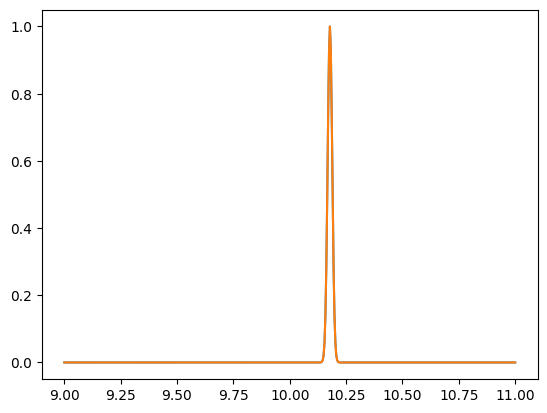

In [14]:
theta_l = ls.minimise(theta_true)
logPr_max_l = ls.logPr(theta_l)
H_l = ls.hess(theta_l)
ds = np.linspace(9, 11, 500)
logprs_l = np.zeros_like(ds)
logprs_ll = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_l[i] = ls.logPr(d)
    logprs_ll[i] = logPr_laplace(d, logPr_max_l, theta_l, H_l[0][0])
plt.plot(ds, np.exp(logprs_l-logprs_l.max()))
plt.plot(ds, np.exp(logprs_ll-logprs_ll.max()))

NameError: name 'nk_dead' is not defined